In [1]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
import tensorflow as tf
from tensorflow.python.framework import ops
from cnn_utils import *

%matplotlib inline
np.random.seed(1)

In [2]:
# Loading the data (signs)
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()

y = 2


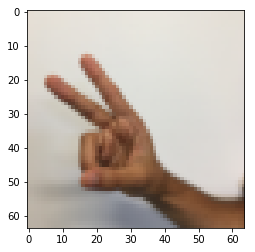

In [3]:
index = 6
plt.imshow(X_train_orig[index])
print ("y = " + str(np.squeeze(Y_train_orig[:, index])))

In [4]:
X_train = X_train_orig/255.
X_test = X_test_orig/255.
Y_train = convert_to_one_hot(Y_train_orig, 6).T
Y_test = convert_to_one_hot(Y_test_orig, 6).T
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))
conv_layers = {}

number of training examples = 1080
number of test examples = 120
X_train shape: (1080, 64, 64, 3)
Y_train shape: (1080, 6)
X_test shape: (120, 64, 64, 3)
Y_test shape: (120, 6)


In [17]:
def create_placeholders(n_H0, n_W0, n_C0, n_y):
    
    X = tf.placeholder(tf.float32,shape=(None, n_H0, n_W0, n_C0))
    Y = tf.placeholder(tf.float32,shape=(None, n_y))
   
    
    return X, Y

In [19]:
def initialize_parameters():
   
    
    tf.set_random_seed(1)                              
        
    
    W1 = tf.get_variable("W1",[4,4,3,8],initializer= tf.contrib.layers.xavier_initializer(seed = 0))
    W2 = tf.get_variable("W2",[2,2,8,16],initializer= tf.contrib.layers.xavier_initializer(seed = 0))
    

    parameters = {"W1": W1,
                  "W2": W2}
    
    return parameters

In [29]:
def forward_propagation(X, parameters):
    
    
    # Retrieve the parameters from the dictionary "parameters" 
    W1 = parameters['W1']
    W2 = parameters['W2']
    
    
    # CONV2D: stride of 1, padding 'SAME'
    Z1 = tf.nn.conv2d(X,W1,strides=[1,1,1,1],padding='SAME')
    # RELU
    A1 = tf.nn.relu(Z1)
    # MAXPOOL: window 8x8, stride 8, padding 'SAME'
    P1 = tf.nn.max_pool(A1,ksize=[1,8,8,1],strides=[1,8,8,1],padding='SAME')
    # CONV2D: filters W2, stride 1, padding 'SAME'
    Z2 = tf.nn.conv2d(P1,W2,strides=[1,1,1,1],padding='SAME')
    # RELU
    A2 = tf.nn.relu(Z2)
    # MAXPOOL: window 4x4, stride 4, padding 'SAME'
    P2 = tf.nn.max_pool(A2,ksize=[1,4,4,1],strides=[1,4,4,1],padding='SAME')
    # FLATTEN
    P2 = tf.contrib.layers.flatten(P2)
    # FULLY-CONNECTED without non-linear activation function (not not call softmax).
    # 6 neurons in output layer. Hint: one of the arguments should be "activation_fn=None" 
    Z3 = tf.contrib.layers.fully_connected(P2, 6,activation_fn=None)
    

    return Z3

In [ ]:
def compute_cost(Z3, Y,parameters):
    
    
    cost = (tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=Z3,labels=Y))
                    +
                    0.001*tf.nn.l2_loss(parameters["W1"]+
                    +0.001*tf.nn.l2_loss(parameters["W2"]))
           )
    
    
    return cost

In [75]:
# GRADED FUNCTION: model

def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.009,
          num_epochs = 200, minibatch_size = 64, print_cost = True):
    """
    
    CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED
    
    Arguments:
    X_train -- training set, of shape (None, 64, 64, 3)
    Y_train -- test set, of shape (None, n_y = 6)
    X_test -- training set, of shape (None, 64, 64, 3)
    Y_test -- test set, of shape (None, n_y = 6)
    learning_rate -- learning rate of the optimization
    num_epochs -- number of epochs of the optimization loop
    minibatch_size -- size of a minibatch
    print_cost -- True to print the cost every 100 epochs
    
    Returns:
    train_accuracy -- real number, accuracy on the train set (X_train)
    test_accuracy -- real number, testing accuracy on the test set (X_test)
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    
    ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
    tf.set_random_seed(1)                             # to keep results consistent (tensorflow seed)
    seed = 3                                          # to keep results consistent (numpy seed)
    (m, n_H0, n_W0, n_C0) = X_train.shape             
    n_y = Y_train.shape[1]                            
    costs = []                                        # To keep track of the cost
    
    
    X, Y = create_placeholders(n_H0, n_W0, n_C0,n_y)
    

    
    parameters = initialize_parameters()
    
    
    Z3 = forward_propagation(X,parameters)
    
    
    cost = compute_cost(Z3,Y,parameters)
    
    
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
    
    init = tf.global_variables_initializer()
     
    
    with tf.Session() as sess:
        
        # Run the initialization
        sess.run(init)
        
        # Do the training loop
        for epoch in range(num_epochs):

            minibatch_cost = 0.
            num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)

            for minibatch in minibatches:

                # Select a minibatch
                (minibatch_X, minibatch_Y) = minibatch
                _ , temp_cost = sess.run([optimizer,cost],feed_dict={X:minibatch_X,Y:minibatch_Y})
                
                
                minibatch_cost += temp_cost / num_minibatches
                

            # Print the cost every epoch
            if print_cost == True and epoch % 5 == 0:
                print ("Cost after epoch %i: %f" % (epoch, minibatch_cost))
            if print_cost == True and epoch % 1 == 0:
                costs.append(minibatch_cost)
        
        
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # Calculate the correct predictions
        predict_op = tf.argmax(Z3, 1)
        correct_prediction = tf.equal(predict_op, tf.argmax(Y, 1))
        
        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        print(accuracy)
        train_accuracy = accuracy.eval({X: X_train, Y: Y_train})
        test_accuracy = accuracy.eval({X: X_test, Y: Y_test})
        print("Train Accuracy:", train_accuracy)
        print("Test Accuracy:", test_accuracy)
                
        return train_accuracy, test_accuracy, parameters

Cost after epoch 0: 1.938321
Cost after epoch 5: 1.538577
Cost after epoch 10: 1.200718
Cost after epoch 15: 1.050000
Cost after epoch 20: 0.961671
Cost after epoch 25: 0.923259
Cost after epoch 30: 0.854445
Cost after epoch 35: 0.866266
Cost after epoch 40: 0.823764
Cost after epoch 45: 0.825607
Cost after epoch 50: 0.792525
Cost after epoch 55: 0.761998
Cost after epoch 60: 0.745151
Cost after epoch 65: 0.776786
Cost after epoch 70: 0.737612
Cost after epoch 75: 0.768851
Cost after epoch 80: 0.710159
Cost after epoch 85: 0.770455
Cost after epoch 90: 0.678231
Cost after epoch 95: 0.675454
Cost after epoch 100: 0.697841
Cost after epoch 105: 0.658163
Cost after epoch 110: 0.628299
Cost after epoch 115: 0.628164
Cost after epoch 120: 0.663095
Cost after epoch 125: 0.663971
Cost after epoch 130: 0.657910
Cost after epoch 135: 0.652313
Cost after epoch 140: 0.650508
Cost after epoch 145: 0.603550
Cost after epoch 150: 0.606678
Cost after epoch 155: 0.609307
Cost after epoch 160: 0.580374

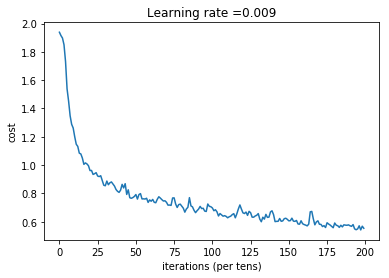

Tensor("Mean_1:0", shape=(), dtype=float32)
Train Accuracy: 0.830556
Test Accuracy: 0.75


In [76]:
_, _, parameters = model(X_train, Y_train, X_test, Y_test)